# Predicting the Margin of NFL Games using linear regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from clean3 import clean_games

In [37]:
# gather & pre-process our data (for details, see clean_game_data.ipynb and clean3.py)
df = clean_games('data/games.pickle', start_year=1990)

In [38]:
game_df = df.copy() # to prevent needing to rerun clean_games

## Feature Selection

See `feature_engineering.ipynb` for more information about the feature selection process.

In [39]:
features = [
    'season_year',
    'team_home_game',
    'ewma_team_home_game',
    'ewma10_margin',
    'ewma10_wins_opp',
    'roll19_wins',
    'roll19_margin_opp',
    'ewma_margin_opp',
    'ewma_margin',
    'ewma_pass_yds_def',
    'ewma_total_yds_def',
    'ewma_total_yds_def_opp',
    'ewma_result_win_opp',
    'ewma_third_conv_pct',
    'ewma_third_conv_pct_opp',
    'ewma_pass_cmp_def',
    'ewma_pass_cmp_perc_def', 
    'ewma_pass_cmp_perc_def_opp', 
    'ewma4_margin_opp',
]

target = 'margin'

print("Number of Features: ", len(features))

Number of Features:  19


In [40]:
all_cols = [c for c in features]
all_cols.append('margin')
model_df = game_df[all_cols]

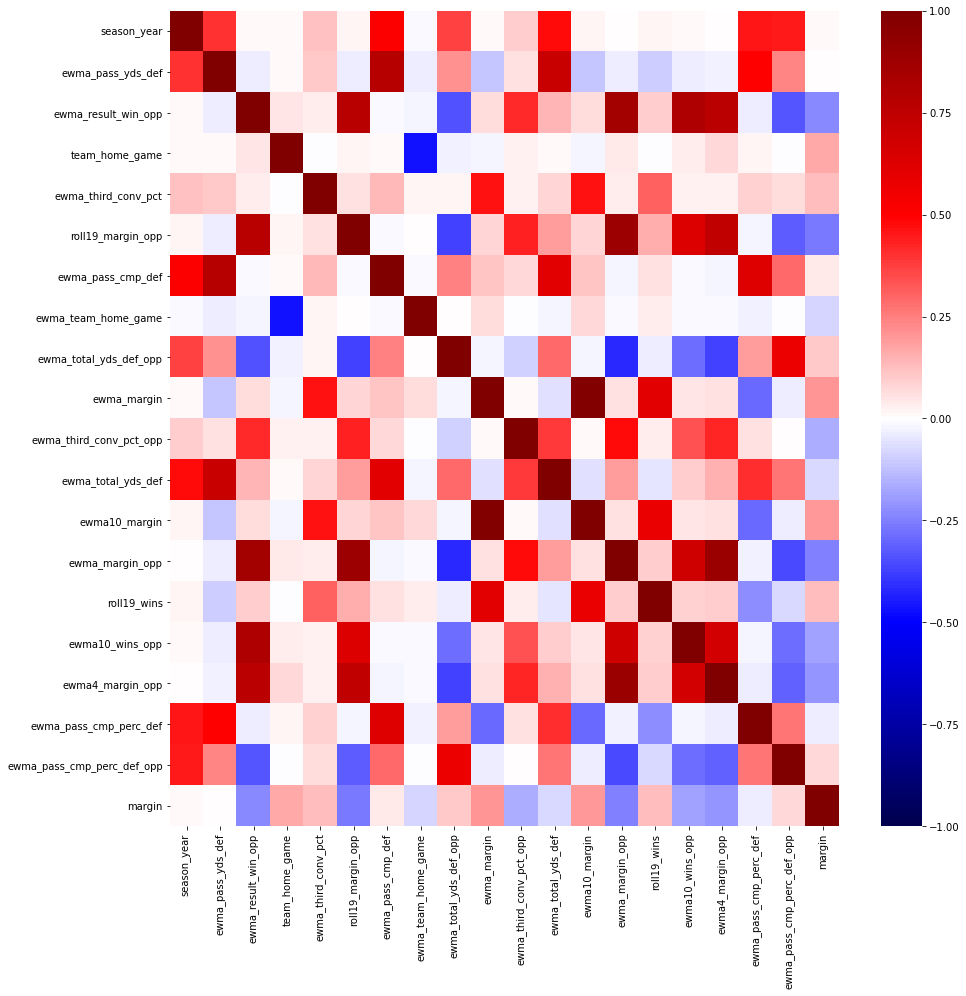

In [41]:

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(game_df[all_cols].corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

In [42]:
game_df.reindex()

,game_id,season_year,week_num,team_year,full_game_date,team,decade,opp,game_day_of_week,game_outcome,...,ewma_to_def_opp,log_year,ewma_third_conv_pct,ewma_third_conv_pct_def,ewma_third_conv_pct_opp,ewma_third_conv_pct_def_opp,ewma_total_yds_off,ewma_total_yds_def,ewma_total_yds_off_opp,ewma_total_yds_def_opp
12,atl-rai-1991-09-22,1991,4.0,atl-1991,1991-09-22,atl,199,rai,Sun,W,...,1.285834,7.596392,0.414545,0.236831,0.444372,0.384148,196.465,311.192,275.041,317.376
16,atl-nor-1991-09-29,1991,5.0,atl-1991,1991-09-29,atl,199,nor,Sun,L,...,2.062954,7.596392,0.415208,0.267617,0.323996,0.201953,209.705,302.268,299.874,213.147
20,atl-sfo-1991-10-13,1991,7.0,atl-1991,1991-10-13,atl,199,sfo,Sun,W,...,1.467015,7.596392,0.366330,0.333438,0.406125,0.399926,189.997,392.980,368.613,283.708
24,atl-crd-1991-10-20,1991,8.0,atl-1991,1991-10-20,atl,199,crd,Sun,L,...,1.939072,7.596392,0.383877,0.390719,0.391666,0.405214,194.481,390.020,288.207,332.186
28,atl-ram-1991-10-27,1991,9.0,atl-1991,1991-10-27,atl,199,ram,Sun,W,...,1.766791,7.596392,0.359075,0.395877,0.382289,0.348152,197.839,367.537,279.497,325.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56488,sea-sfo-2020-11-01,2020,8.0,sea-2020,2020-11-01,sea,202,sfo,Sun,W,...,1.575977,7.610853,0.334001,0.480642,0.433014,0.344198,300.811,606.242,386.013,306.406
56516,sea-was-2020-12-20,2020,15.0,sea-2020,2020-12-20,sea,202,was,Sun,W,...,1.359437,7.610853,0.407098,0.447129,0.357849,0.356448,257.488,469.465,316.120,310.254
56524,sea-sfo-2021-01-03,2020,17.0,sea-2020,2021-01-03,sea,202,sfo,Sun,W,...,1.866593,7.610853,0.419085,0.470560,0.372161,0.338475,234.641,505.893,376.277,315.867
56574,sfo-was-2020-12-13,2020,14.0,sfo-2020,2020-12-13,sfo,202,was,Sun,L,...,1.182742,7.610853,0.407858,0.375742,0.384705,0.372204,262.378,457.983,335.184,305.029


In [43]:
X = model_df[features]
y = game_df[target]

## Perform Train/Test Split

I will be using an 80/20 Train/Test split. Note that despite all of the cross-validation we completed in `feature_selection.ipynb`, we still have yet to predict `y_test` using `X_test` data.

The reason we haven't yet used our test set is to prevent overfitting. By holding these out and engineering the features we're including in our model, we should avoid **overfitting**. This would result in our model recognizing outliers as patterns and ultimately the inability to generalize to fresh inputs.

In [53]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, lars_path
from sklearn.metrics import mean_squared_error, mean_absolute_error

def cross_validate_lr(X, y):
    '''
        Performs K-Fold cross-validation on linear regression model and computes model metrics

        Features are scaled using standard scaler.

        ------------------
        Parameters:

        - X: DataFrame or numpy array of features/independent variables from training set
        - y: DataFrame or numpy array of target/dependent variable from training set

        ------------------
        Returns:
        
        - model

        Model metrics with cross-validation: R^2 score for training and validation sets
        with each fold, mean R^2 score for validation set across all folds;
        mean training/validation score ratios, MAE, RMSE across all folds
    '''
    
    train_results = []
    val_results = []
    ratios = []
    maes = []
    rmses = []
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)   # default values
    
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):
        print(len(train_ind), len(val_ind))
        
        # iterate thru 5 shuffled train/validation sets & collect results
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        
        # standardize data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)
        X_val_scaled = scaler.transform(X_val.values)
        X_test_scaled = scaler.transform(X_test.values) # scaling test set now
        
        # fit linear model to the standardized train dataset
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # validate
        y_pred = model.predict(X_val)
        
        # store results
        train_results.append(model.score(X_train_scaled, y_train))
        val_results.append(model.score(X_val_scaled, y_val))
        ratios.append(model.score(X_train_scaled, y_train) / model.score(X_val_scaled, y_val))
        maes.append(mean_absolute_error(y_val, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        
    # summarize results    
    print('Linear regression train R^2:', train_results)
    print('-----------')
    print('Linear regression val R^2: \n ', val_results)
    print('-----------')
    print(f'Linear regression mean val R^2: {np.mean(val_results):.3f} +- {np.std(val_results):.3f}')
    print('-----------')
    print(f'Mean train/val R^2 ratio: {np.mean(ratios):.3f} +- {np.std(ratios):.3f}')
    print('-----------')
    print('Mean MAE: ', np.mean(maes))
    print('-----------')
    print('Mean RMSE: ', np.mean(rmses))
    
    return model, X_test_scaled, y_test, scaler

In [54]:
model, X_test_scaled, y_test, scaler = cross_validate_lr(X, y)

3820 956
3821 955
3821 955
3821 955
3821 955
Linear regression train R^2: [0.16603781810820528, 0.1606730523999419, 0.169757759313373, 0.16572253537969395, 0.16617404764363164]
-----------
Linear regression val R^2: 
  [0.1550644377958924, 0.17537005437469577, 0.13816525203774044, 0.15722800352147592, 0.15050269215490442]
-----------
Linear regression mean val R^2: 0.155 +- 0.012
-----------
Mean train/val R^2 ratio: 1.075 +- 0.100
-----------
Mean MAE:  363.6543193048456
-----------
Mean RMSE:  408.49420142190854


In [86]:
model.score(X_test_scaled, y_test)

0.1428633368352068

Not bad! The model generalized fairly well - less than 0.15 lower than our mean cross-validation $R^2$.

Let's take a look at our features and their corresponding slopes/coefficients

In [87]:
for feature, coef in zip(features, model.coef_):
    print(feature, ': ', coef)

season_year :  -0.11851926531775794
ewma_pass_yds_def :  0.9239033048824528
ewma_result_win_opp :  -1.005929190130019
team_home_game :  2.6795437645241567
ewma_third_conv_pct :  0.6025667708631599
roll19_margin_opp :  -2.7675807554472014
ewma_pass_cmp_def :  -0.05890197371360179
ewma_team_home_game :  -0.18770001255477914
ewma_total_yds_def_opp :  0.33284303979207047
ewma_margin :  4.966457558397433
ewma_third_conv_pct_opp :  -0.3818661666573145
ewma_total_yds_def :  -0.8549262021315663
ewma10_margin :  -1.8491736749707677
ewma_margin_opp :  0.004295074341597852
roll19_wins :  0.2547303310064045
ewma10_wins_opp :  0.2309458755730572
ewma4_margin_opp :  -0.5245631453779563
ewma_pass_cmp_perc_def :  -0.0693075835179363
ewma_pass_cmp_perc_def_opp :  -0.4252033606773436


In [56]:
model.coef_

array([-1.18519265e-01,  9.23903305e-01, -1.00592919e+00,  2.67954376e+00,
        6.02566771e-01, -2.76758076e+00, -5.89019737e-02, -1.87700013e-01,
        3.32843040e-01,  4.96645756e+00, -3.81866167e-01, -8.54926202e-01,
       -1.84917367e+00,  4.29507434e-03,  2.54730331e-01,  2.30945876e-01,
       -5.24563145e-01, -6.93075835e-02, -4.25203361e-01])

In [57]:

test_df = pd.DataFrame(X_test_scaled)
test_df['prediction'] = model.predict(test_df)
test_df['actual'] = y_test
test_df['resid'] = test_df['prediction'] - test_df['actual']

In [82]:
# try to get everything back into one DF

test_df = pd.DataFrame(X_test_scaled)
test_df['prediction'] = pd.Series(preds)
test_df['actual'] = y_test
test_df['resid'] = test_df['prediction'] - test_df['actual']

cols = [f for f in features]
cols.append('prediction')
cols.append('actual')
cols.append('resid')


test_df.columns = cols
test_df

,season_year,ewma_pass_yds_def,ewma_result_win_opp,team_home_game,ewma_third_conv_pct,roll19_margin_opp,ewma_pass_cmp_def,ewma_team_home_game,ewma_total_yds_def_opp,ewma_margin,...,ewma10_margin,ewma_margin_opp,roll19_wins,ewma10_wins_opp,ewma4_margin_opp,ewma_pass_cmp_perc_def,ewma_pass_cmp_perc_def_opp,prediction,actual,resid
0,1.268250,0.908438,1.076219,1.008146,-0.483452,1.843435,0.758113,-0.903879,2.049103,-0.358871,...,-0.409130,1.889783,-0.238348,0.951202,2.419386,-0.218256,1.095562,-8.104778,NaN,NaN
1,2.394175,0.065893,0.595497,1.008146,-0.146089,0.226077,0.431094,0.164716,1.467252,0.851558,...,0.773584,0.063337,0.750141,0.951202,-0.182206,1.056019,1.582467,3.120066,NaN,NaN
2,-0.702119,-0.479123,-0.863989,-0.991920,-1.397891,-0.775145,-0.181388,0.196457,0.009312,-1.076616,...,-1.066193,-0.889853,-0.897340,-1.051301,-0.860882,-0.241806,-0.122854,-4.116294,NaN,NaN
3,0.705287,-0.628618,-0.708080,-0.991920,1.961055,-0.667321,0.537692,0.228197,-0.173690,0.814297,...,1.036409,-0.561647,1.738630,-1.051301,-0.634657,1.851798,0.232307,2.405633,NaN,NaN
4,1.690472,0.518378,-0.339960,-0.991920,0.734998,-0.559497,0.596230,-0.734597,1.057167,-0.724135,...,-1.197606,0.083696,0.420645,-1.051301,1.401372,1.487200,0.949134,-3.801240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,-1.124341,-0.196574,-0.920290,1.008146,0.605297,-0.066588,-0.019505,-1.411727,0.753948,-1.082871,...,-1.197606,-0.149136,-1.226837,-1.051301,-0.521544,-0.114421,0.435796,-0.211590,NaN,NaN
1191,0.705287,0.683360,1.279767,1.008146,0.792900,2.136099,0.673919,0.778366,-2.045414,-0.130683,...,-0.014892,1.114633,1.738630,0.951202,1.062034,0.419524,-1.401897,-5.431648,NaN,NaN
1192,-0.420638,-0.826483,0.305332,-0.991920,-0.718629,0.549548,-1.085839,-0.300810,-1.214823,-1.128971,...,-1.197606,0.933177,-0.897340,0.951202,0.609583,-1.445644,-0.948977,-9.709347,NaN,NaN
1193,0.001584,-0.910779,0.928971,-0.991920,0.495058,0.796003,-0.144170,1.064030,-0.424856,1.469760,...,1.299235,1.082387,0.420645,0.951202,0.948921,1.132022,0.326080,-2.004834,NaN,NaN


In [73]:
test_df['prediction'] = 

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [63]:
sns.scatterplot(model.coef_, test_df.resid)

/Users/ewilens/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: array length 19 does not match index length 1195

In [59]:
test_df.shape()

TypeError: 'tuple' object is not callable

(1195,)